# Paths

In [1]:
EXAMPLE_ROOT = 'Example04'
NEWSGROUP_JSON_PATH = f'{EXAMPLE_ROOT}/newsgroups.json'
NEWSGROUP_CONTENT_RAW_TXT_PATH = f'{EXAMPLE_ROOT}/01_newsgroups_content_raw.txt'
NEWSGROUP_LINES_RAW_TXT_PATH = f'{EXAMPLE_ROOT}/02_newsgroups_lines_raw.txt'
NEWSGROUP_CLEAN_TXT_PATH = f'{EXAMPLE_ROOT}/03_newsgroups_clean.txt'
NEWSGROUP_LEMINIZED_PATH = f'{EXAMPLE_ROOT}/04_leminized.txt'
NEWSGROUP_LEMINIZED_NO_STOP_PATH = f'{EXAMPLE_ROOT}/05_leminized_no_stop.txt'

# Import Dataset

In [2]:
import pandas as pd

df = pd.read_json(NEWSGROUP_JSON_PATH)

df.head(15)

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc
10000,From: a207706@moe.dseg.ti.com (Robert Loper)\n...,7,rec.autos
10001,From: kimman@magnus.acs.ohio-state.edu (Kim Ri...,6,misc.forsale
10002,From: kwilson@casbah.acns.nwu.edu (Kirtley Wil...,2,comp.os.ms-windows.misc
10003,Subject: Re: Don't more innocents die without ...,0,alt.atheism
10004,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,0,alt.atheism


# Data Preprocessing

In [3]:
import re, string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import random

lemmatizer = WordNetLemmatizer()
stopWords = set(stopwords.words('english'))

def remove_section(pattern, data):
    return [re.sub(pattern, '', sent, flags = re.I) for sent in data]

def sentence_to_words(sentences):
    return [sent.split(' ') for sent in sentences]
        
def dump_to_file(filePath, data):
    with open(filePath, 'w') as f:
        for item in data:
            f.write("%s\n" % item.encode("utf-8"))

def leminize_data_words(data_words):
    return [lemmatizer.lemmatize(word) for word in data_words]

def filter_out_stop_words(data_words):
    return [word for word in data_words if word not in stopWords]

def remove_empty_words(data_words):
    return [word for word in data_words if word]

def join(data_words_sentences):
    return [' '.join(sent) for sent in data_words_sentences]

# Convert to list
data = df.content.values.tolist()

# Limit amount of data for testing, take N random entries
data = random.sample(data, 2000)

dump_to_file(NEWSGROUP_CONTENT_RAW_TXT_PATH, data)

# Remove unrequired entries
data = remove_section('Re:', data)
data = remove_section('Reply-To:.*', data)
data = remove_section('From:.*', data)
data = remove_section('Organization:.*', data)
data = remove_section('Nntp-Posting-Host:.*', data)
data = remove_section('Distribution:.*', data)
data = remove_section('Article-I.D.:.*', data)
data = remove_section('Keywords:.*', data)
data = remove_section('Expires:.*', data)
data = remove_section('Subject:', data)
data = remove_section('Lines: [0-9]+', data)

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

dump_to_file(NEWSGROUP_LINES_RAW_TXT_PATH, data)

# Replace unwanted characters
data = [re.sub('[^A-Za-z]', ' ', sent) for sent in data]

# transform to lowercase
data = [sent.lower() for sent in data]

# remove double spaces
data = [re.sub("\ +", " ", sent) for sent in data]

# trim sentences
data = [sent.strip() for sent in data]

dump_to_file(NEWSGROUP_CLEAN_TXT_PATH, data)

# convert sentences to words
data_words_sentences = sentence_to_words(data)

# perform leminization
data_words_sentences = [leminize_data_words(data_words) for data_words in data_words_sentences]

dump_to_file(NEWSGROUP_LEMINIZED_PATH, join(data_words_sentences))

# filter out stop words
data_words_sentences = [filter_out_stop_words(data_words) for data_words in data_words_sentences]

# remove empty words
data_words_sentences = [remove_empty_words(data_words) for data_words in data_words_sentences]

#convert to sentences
data_words_sentences = join(data_words_sentences)

dump_to_file(NEWSGROUP_LEMINIZED_NO_STOP_PATH, data_words_sentences)

# Document-Word matrix

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word', min_df=3)

data_vectorized = vectorizer.fit_transform(data_words_sentences)

# LDA Model

In [5]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [3, 5, 8, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

best_lda_model = model.best_estimator_

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


# Dominant Topics

In [6]:
import numpy as np

# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.27,0.4,0.33,1
Doc1,0.47,0.52,0.01,1
Doc2,0.57,0.02,0.41,0
Doc3,0.01,0.04,0.96,2
Doc4,0.01,0.98,0.01,1
Doc5,0.75,0.13,0.12,0
Doc6,0.29,0,0.71,2
Doc7,0.01,0.19,0.81,2
Doc8,0.98,0.01,0.01,0
Doc9,0.53,0.12,0.35,0


# Topics distribution across documents

In [7]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,2,832
1,1,642
2,0,526


# Top 15 keywords each topic

In [8]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,file,edu,window,com,system,use,thanks,mail,problem,drive,please,new,get,card,work
Topic 1,one,wa,edu,would,ha,people,writes,use,god,system,key,like,com,also,article
Topic 2,wa,edu,writes,article,would,one,com,ha,like,time,get,people,think,year,know


# Cluster documents

In [9]:
from sklearn.decomposition import TruncatedSVD

# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=best_lda_model.n_components, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.29  0.4   0.87]
 [ 0.2   0.86 -0.46]]
Perc of Variance Explained: 
 [0.1  0.52]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

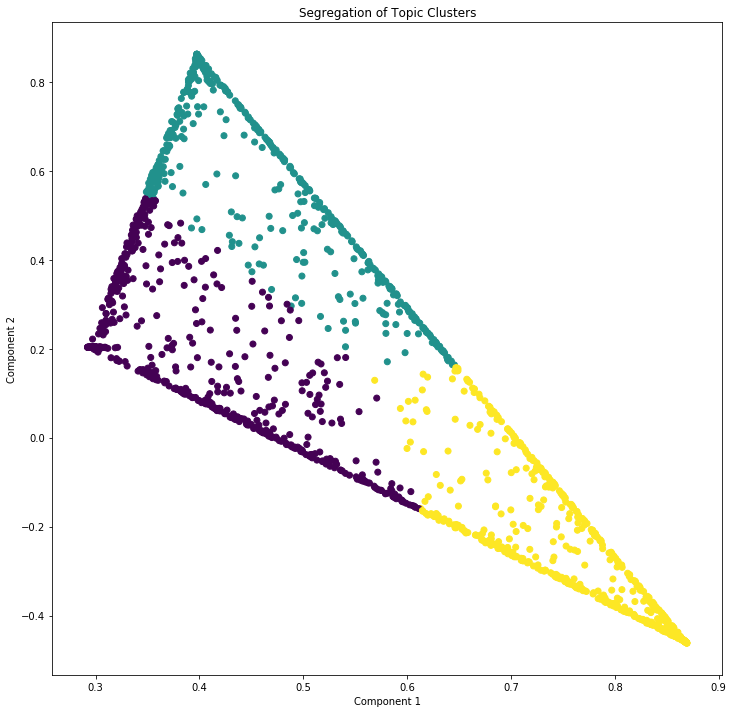

In [10]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title("Segregation of Topic Clusters", )